# Data Loader Prototype

This notebook is intended to serve as a developmental prototype testing environment for `zarr` dataloaders configured for multi-GPU processing. 

In [1]:
import sys
from pathlib import Path
import numpy as np
import torchvision
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader, ChainDataset, ConcatDataset, IterableDataset
from torch.cuda.amp import autocast
import torch.multiprocessing as mp
import zarr
import zarrdataset as zds
import matplotlib.pyplot as plt

from aind_octo_data_loaders.transforms import ScaleUint16ToFloat3D

# Add the src directory to the Python path
sys.path.append("../src/aind_octo_data_loaders")
from utils import plot_mips

mp.set_start_method("spawn", force=True)


In [2]:
#DATASET_PATH = "s3://aind-open-data/SmartSPIM_772899_2025-02-08_01-59-55/SPIM/Ex_488_Em_525/486060_719760.ome.zarr"
#DATASET_PATH = "s3://aind-open-data/SmartSPIM_772899_2025-02-08_01-59-55/SPIM/Ex_561_Em_600/486060_771600.ome.zarr"
#DATASET_PATH = "s3://aind-open-data/HCR_704576_2024-04-22_13-00-00/SPIM.ome.zarr/R0_X_0000_Y_0003_Z_0000_ch_40.zarr"  # HCR
DATASET_PATH = "s3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr" # SmartSPIM
DATASET_PATH2 = "s3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr"  # Proteomics

In [3]:
z_img = zarr.open(DATASET_PATH, mode="r")
z_img["2"].info

Name,/2
Type,zarr.core.Array
Data type,uint16
Shape,"(1, 1, 864, 768, 1856)"
Chunk shape,"(1, 1, 128, 128, 128)"
Order,C
Read-only,True
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,2463105024 (2.3G)
No. bytes stored,443


In [4]:
my_patch_sampler = zds.PatchSampler(
    patch_size=dict(X=256,Y=256,Z=256)
    )


# Kornia Augmentations

In [5]:
img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16)
])

In [6]:
import kornia.augmentation as K
import zarrdataset as zds

In [7]:
import importlib
import neurobase
importlib.reload(neurobase)

<module 'neurobase' from '/home/geoff/aind/neurobase/neurobase/__init__.py'>

In [8]:
%load_ext autoreload
%autoreload 2

In [10]:
from neurobase.transform import ConvertToFloat32

In [11]:
img_preprocessing = K.AugmentationSequential(
    neurobase.transform.ConvertToFloat32(),

    K.RandomDepthicalFlip3D(
        p=0.5,
    ),

    K.RandomHorizontalFlip3D(
        p=0.5,
    ),
    K.RandomVerticalFlip3D(
        p=0.5,
    ),
    
    # 3D Resized Crop (analogous to 2D RandomResizedCrop)
    K.RandomCrop3D(
        size=(128, 128, 128),
        align_corners=False,
        p=0.5
    ),
    
    # 3D Affine Transformation (generalized to 3D)
    K.RandomAffine3D(
        degrees=1,             # Rotation degrees
        translate=(0.01, 0.01, 0.01),  # Translation
        scale=(0.99, 1.01),
        p=0.4,
        align_corners=False
    ),
    # Normalize3D(
    #     mean=7717.55224609375,
    #     std=5060.521484375
    # ),

    #zds.ToDtype(
    #    dtype=np.float16
    #),
    
    random_apply=False,
    keepdim=True
)

# Instantiating Specs

In [12]:
specs = zds.ImagesDatasetSpecs(
      modality="images",
      filenames=[DATASET_PATH, DATASET_PATH2],
      source_axes="TCZYX",
      data_group="1",
      transform=img_preprocessing,
    )

In [13]:
specs

{'modality': 'images',
 'filenames': ['s3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr',
  's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr'],
 'source_axes': 'TCZYX',
 'axes': None,
 'data_group': '1',
 'roi': None,
 'image_loader_func': None,
 'transforms': [(('images',),
   AugmentationSequential(
     (ConvertToFloat32_0): ConvertToFloat32()
     (RandomDepthicalFlip3D_1): RandomDepthicalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
     (RandomHorizontalFlip3D_2): RandomHorizontalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
     (RandomVerticalFlip3D_3): RandomVerticalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
     (RandomCrop3D_4): RandomCrop3D(crop_size=(128, 128, 128), p=1.0, p_batch=0.5, same_on_batch=False, size=(128, 128, 128), padding=None, pad_if_needed=False, padding_mode=constant, fill=0, resample=bilinear, align_corners=False)
  

In [14]:
my_dataset = zds.ZarrDataset(
  [
    zds.ImagesDatasetSpecs(
      modality="images",
      filenames=[DATASET_PATH,DATASET_PATH2],
      source_axes="TCZYX",
      data_group="1",
      transform=img_preprocessing,
    ),
  ],
  patch_sampler=my_patch_sampler,
  shuffle=True,
  return_positions=False,
  return_worker_id=False
)

In [15]:
print(my_dataset)

ZarrDataset (PyTorch support:True, tqdm support :True)
Modalities: images
Transforms order: 
	('images',): ConvertToFloat32()
	('images',): RandomDepthicalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
	('images',): RandomHorizontalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
	('images',): RandomVerticalFlip3D(p=0.5, p_batch=1.0, same_on_batch=False)
	('images',): RandomCrop3D(crop_size=(128, 128, 128), p=1.0, p_batch=0.5, same_on_batch=False, size=(128, 128, 128), padding=None, pad_if_needed=False, padding_mode=constant, fill=0, resample=bilinear, align_corners=False)
	('images',): RandomAffine3D(degrees=1, shears=None, translate=(0.01, 0.01, 0.01), scale=(0.99, 1.01), p=0.4, p_batch=1.0, same_on_batch=False, resample=bilinear, align_corners=False)

Using images modality as reference.
Using <class 'zarrdataset._samplers.PatchSampler'> for sampling patches of size {'Z': 256, 'Y': 256, 'X': 256}.


In [16]:
my_dataset._collections

{'images': [{'filename': 's3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr',
   'data_group': '1',
   'source_axes': 'TCZYX',
   'axes': 'TCZYX',
   'roi': None},
  {'filename': 's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr',
   'data_group': '1',
   'source_axes': 'TCZYX',
   'axes': 'TCZYX',
   'roi': None}]}

In [17]:
sample = next(iter(my_dataset))

In [19]:
sample.max()

tensor(14.0140)

In [ ]:
from zarrdataset._imageloaders import ImageCollection

modes = my_dataset._collections.keys()
for collection in zip(*my_dataset._collections.values()):
    print(collection)
    collection = {m: c for m, c in zip(modes, collection)}
    il = ImageCollection(collection)

({'filename': 's3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr', 'data_group': '1', 'source_axes': 'TCZYX', 'axes': 'TCZYX', 'roi': None},)
({'filename': 's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr', 'data_group': '1', 'source_axes': 'TCZYX', 'axes': 'TCZYX', 'roi': None},)


In [ ]:
modes

dict_keys(['images'])

In [ ]:
collection

{'images': {'filename': 's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr',
  'data_group': '1',
  'source_axes': 'TCZYX',
  'axes': 'TCZYX',
  'roi': None}}

In [ ]:
#import tifffile

In [ ]:
#tifffile.imread('s3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr')

In [ ]:
ds_iterator = iter(my_dataset)

In [ ]:
sample = next(ds_iterator)

	 filename: s3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr
	 filename: s3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr


In [ ]:
sample.shape

(1, 1, 256, 256, 256)

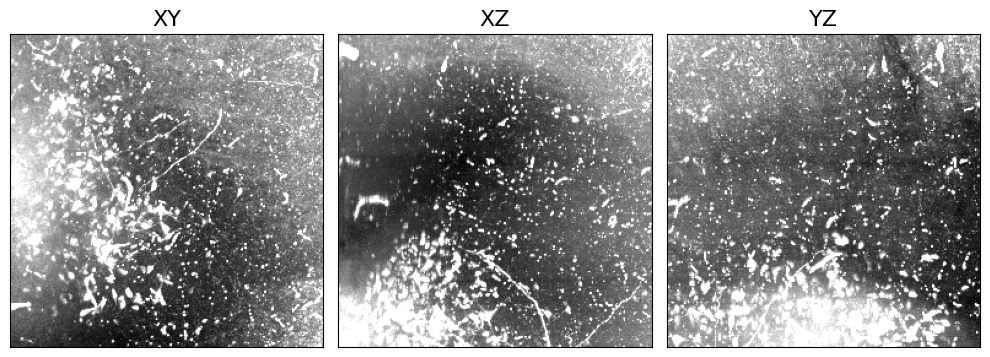

In [ ]:
plot_mips(sample[0,0,...])

# Dataloader   


In [ ]:
my_dataloader = DataLoader(
    my_dataset,
    batch_size=4,
    num_workers=0,
    worker_init_fn=zds.zarrdataset_worker_init_fn
    )

In [ ]:
dl_iterator = iter(my_dataloader)

In [ ]:
batch = next(dl_iterator)

In [ ]:
for i, batch in enumerate(my_dataloader):
    # The training loop
    print(batch.shape)
    break

torch.Size([4, 1, 1, 256, 256, 256])


In [ ]:
batch.shape

torch.Size([4, 1, 1, 256, 256, 256])

In [ ]:
def plot_2d_slice(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    

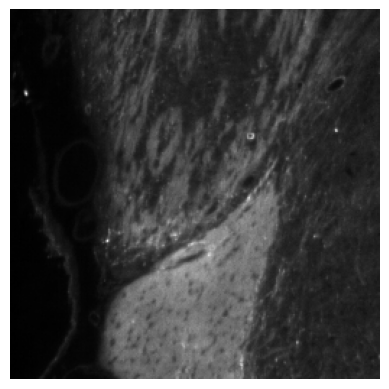

In [ ]:
plot_2d_slice(batch[0,0,0,:,:,128])

# Load Configuration

In [ ]:
import yaml

def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [ ]:
cfg_file = "../configs/example_data.yaml"
cfg = load_config(cfg_file)
print(cfg)

{'dataset': {'train': {'paths': ['s3://aind-open-data/HCR_704576_2024-04-22_13-00-00/SPIM.ome.zarr/R0_X_0000_Y_0003_Z_0000_ch_405.zarr', 's3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr', 's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr']}}, 'loader': {'batch_size': 8, 'data_scale': 1, 'patch_size': 256, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}}


In [ ]:
print(cfg["dataset"]["train"]["paths"])

['s3://aind-open-data/HCR_704576_2024-04-22_13-00-00/SPIM.ome.zarr/R0_X_0000_Y_0003_Z_0000_ch_405.zarr', 's3://aind-open-data/SmartSPIM_722649_2025-04-08_13-01-09_stitched_2025-04-09_06-15-07/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr', 's3://aind-open-data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0001_Y_0029_Z_0000_ch_488.ome.zarr']


In [ ]:
cfg["loader"]

{'batch_size': 8,
 'data_scale': 1,
 'patch_size': 256,
 'shuffle': True,
 'num_workers': 4,
 'pin_memory': True}

In [ ]:
# setup image transforms

img_tx = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16),
    torchvision.transforms.Lambda(lambda x: x.squeeze(1)),
    ScaleUint16ToFloat3D(method="zscore"),
])



In [ ]:
# setup patch sampler

patch_sampler = zds.PatchSampler(
    patch_size=dict(
        X=cfg["loader"]["patch_size"],
        Y=cfg["loader"]["patch_size"],
        Z=cfg["loader"]["patch_size"])
)

NameError: name 'cfg' is not defined

In [ ]:
type(cfg["loader"]["data_scale"])

int

# Dataset Types
- Chain
- Concat
- Iterable


In [ ]:
class MultiSourceIterableDataset(IterableDataset):
    def __init__(self, datasets):
        self.datasets = datasets

    def __iter__(self):
        for ds in self.datasets:
            yield from iter(ds)


In [ ]:
#my_dataset = ChainDataset([
my_dataset = MultiSourceIterableDataset([
  zds.ZarrDataset(
    dataset_specs=[
      zds.ImagesDatasetSpecs(
        filenames=fn,
        data_group=str(cfg["loader"]["data_scale"]),
        source_axes="TCZYX",
        transform=img_tx,
      )
    ],
    patch_sampler=patch_sampler,
    shuffle=cfg["loader"]["shuffle"],
    return_positions=False,
    return_worker_id=False
  )
  for fn in cfg["dataset"]["train"]["paths"]
])

NameError: name 'MultiSourceIterableDataset' is not defined

In [ ]:
my_dataset

In [ ]:
dataloader = DataLoader(
    my_dataset,
    #num_workers=0,
    worker_init_fn=zds.chained_zarrdataset_worker_init_fn,
    batch_size=cfg["loader"]["batch_size"],
)

In [ ]:
print(dataloader)

In [ ]:
#worker_ids, positions, batch = next(iter(dataloader))
batch = next(iter(dataloader))

In [ ]:
batch.shape

torch.Size([8, 1, 256, 256, 256])

In [ ]:
[(i.min(), i.max()) for i in batch]

[(tensor(-1.0419), tensor(9.9231)),
 (tensor(-0.8642), tensor(24.7623)),
 (tensor(-0.8651), tensor(265.3038)),
 (tensor(-0.4582), tensor(222.5787)),
 (tensor(-0.7176), tensor(282.3035)),
 (tensor(-0.2529), tensor(102.3756)),
 (tensor(-2.7471), tensor(183.9464)),
 (tensor(-0.5387), tensor(147.0059))]

# MAE Integration Prototype

Here, we are beginning with a single batch of data that we want to flow through an MAE.

In [ ]:
from aind_lightsheet_mae.model.mae3d import Lightsheet3DMAE

/home/geoff/miniconda3/envs/dl-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batch.shape

torch.Size([8, 1, 256, 256, 256])

In [ ]:
batch.squeeze(1).shape

torch.Size([8, 256, 256, 256])

In [ ]:
reconstruction_model = Lightsheet3DMAE(
    mask_ratio=0.4,
    img_size=(256, 256, 256),
    patch_size=(32, 32, 32),
    in_chans=1,
    embed_dim=128,
    depth=4,
    num_heads=4,
    decoder_embed_dim=128,
    decoder_depth=4,
    decoder_num_heads=4,
    mlp_ratio=2.0,
    norm_layer=torch.nn.LayerNorm,
    norm_pix_loss=False,
    )
reconstruction_model.to("cuda")

Lightsheet3DMAE(
  (model): MaskedAutoencoderViT_3D(
    (l1_loss): PatchedL1Loss()
    (fourier_loss_hl): FourierLoss3DHighLow(
      (loss): L1Loss()
    )
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(32, 32, 32), stride=(32, 32, 32))
    )
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=128, out_features=256, bias=True)
          (act): GELU(approximate='none')


In [ ]:
with torch.autocast("cuda", torch.float32):
    loss, pred, mask = reconstruction_model(batch.to("cuda"))

In [ ]:
pred.min(), pred.max()

(tensor(nan, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(nan, device='cuda:0', grad_fn=<MaxBackward1>))

In [ ]:
pred.shape

torch.Size([8, 512, 32768])

In [ ]:
mask.shape

torch.Size([8, 512])